In [6]:
import cv2
import glob
from palette_classification import palette, color_processing
from palette_classification.palettes import mappings
from utils import utils
import torchvision.transforms as T
import torch
import json
from retrieval import clothes_segmentation

In [7]:
palettes_path = 'palette_classification/palettes/'
palette_mappings_path = 'palette_classification/clothing_palette_mappings/'
dresscode_dataset_paths = {
    'upper_body': 'dresscode_test_dataset/upper_body/',
    'lower_body': 'dresscode_test_dataset/lower_body/',
    'dresses': 'dresscode_test_dataset/dresses/',
}

# loading palettes
palette_filenames = glob.glob(palettes_path + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

autumn


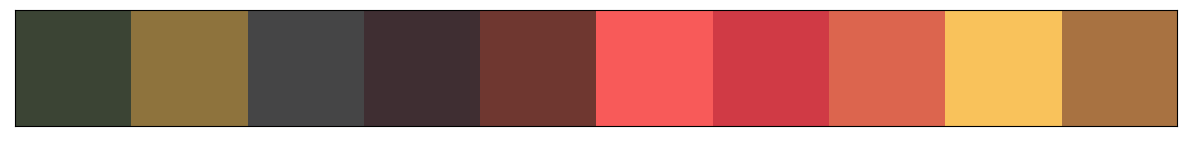

spring


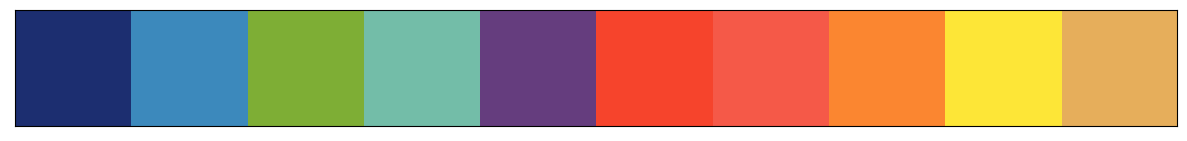

summer


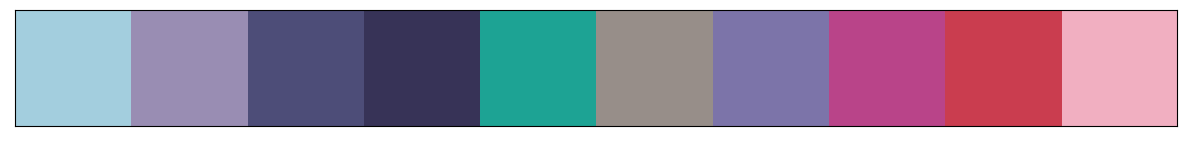

winter


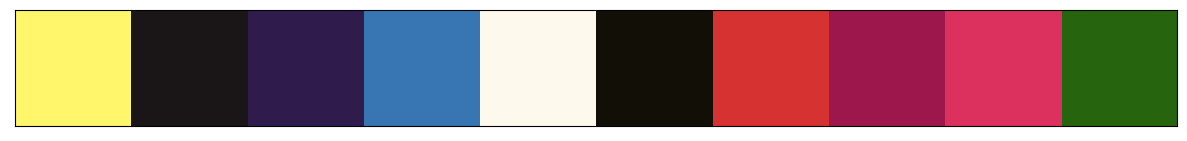

In [8]:
for reference_palette in reference_palettes:
  print(reference_palette.description())
  reference_palette.plot(tile_size=15)

In [9]:
for category in dresscode_dataset_paths:
    mapping_dict_for_category = {} # dict mapping between images and reference palettes
    img_paths_for_category = glob.glob(dresscode_dataset_paths[category] + 'images/*.jpg')
    n_images = len(img_paths_for_category)
    print(f'\nClassification of {category} images...')

    for i, img_path in enumerate(img_paths_for_category):
        img_path = img_path.replace('\\', '/')
        img_filename = img_path.split('/')[-1]
        print(f'|__Classification of image {i+1}/{n_images}...')

        # computing masked and resized image
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = utils.from_HWD_to_DHW(torch.from_numpy(img))
        _, H, W = img.shape
        resize = T.Compose([T.Resize((H // 3, W // 3))])
        mask = clothes_segmentation.segment_img_cloth(img_path)
        mask_eroded = color_processing.erode_segmentation_mask(mask, kernel_size=50)
        img_masked = color_processing.apply_masks(img, mask_eroded)
        img_masked_resized = resize(img_masked)

        # computing cloth embedding and assigning season palette
        cloth_embedding = color_processing.compute_cloth_embedding(
            img_masked_resized, max_length=8, ignored_colors=[[0, 0, 0]])
        cloth_palette = palette.PaletteRGB('cloth', cloth_embedding)
        cloth_season_palette = palette.classify_cloth_palette(
            cloth_palette, reference_palettes, distance_type='avg')

        mapping_dict_for_category[img_filename] = mappings.DESC_ID_MAPPING[cloth_season_palette.description()]
        
    # saving mapping dict for category as json
    with open(palette_mappings_path + category + '/' + category + '_palette_mappings.json', 'w') as outfile:
        json.dump(mapping_dict_for_category, outfile)
        print(f'|__Saved palette mappings for {category} category.')


Classification of upper_body images...
|__Classification of image 1/1798...
|__Classification of image 2/1798...
|__Classification of image 3/1798...
|__Classification of image 4/1798...
|__Classification of image 5/1798...
|__Classification of image 6/1798...
|__Classification of image 7/1798...
|__Classification of image 8/1798...
|__Classification of image 9/1798...
|__Classification of image 10/1798...
|__Classification of image 11/1798...
|__Classification of image 12/1798...
|__Classification of image 13/1798...
|__Classification of image 14/1798...
|__Classification of image 15/1798...
|__Classification of image 16/1798...
|__Classification of image 17/1798...
|__Classification of image 18/1798...
|__Classification of image 19/1798...
|__Classification of image 20/1798...
|__Classification of image 21/1798...
|__Classification of image 22/1798...
|__Classification of image 23/1798...
|__Classification of image 24/1798...
|__Classification of image 25/1798...
|__Classification o